# Toronto Streetscore - CNN with Keras

In [2]:
import numpy as np 
import pandas as pd 
import os, sys
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.pyplot import imshow
import gc

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

from keras import layers
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout
from keras.models import Sequential, Model, load_model, model_from_yaml
from keras.optimizers import SGD
from keras.constraints import maxnorm

import keras.backend as K
from keras.models import Sequential

import lime
from lime import lime_image

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)


In [34]:
# importing the Toronto data for testing the model
toronto_md = pd.read_json("toronto/metadata/metadata.json")
toronto_md.rename(columns = {'_file':'Image_Id'}, inplace = True)
toronto_md.head()

,Image_Id,copyright,date,location,pano_id,status
0,gsv_0.jpg,© Google,2018-07-01,"{'lng': -79.44444515468172, 'lat': 43.68140750...",aLRQFLoboL6papa2qE1Veg,OK
1,gsv_1.jpg,© Google,2018-08-01,"{'lng': -79.49215639665093, 'lat': 43.74883494...",hwo_vjTqlVcqF-my9fjVhw,OK
2,gsv_2.jpg,© Google,2018-08-01,"{'lng': -79.18330303841032, 'lat': 43.75852320...",1yc7mFQX1OGCMh2n9OvtRQ,OK
3,gsv_3.jpg,© Google,2018-08-01,"{'lng': -79.40845388329201, 'lat': 43.64732825...",hHP4wWeB0Ak1eqRV6ncfhg,OK
4,gsv_4.jpg,© Google,2018-08-01,"{'lng': -79.1795913, 'lat': 43.7604919}",bw_AvWlyXIOe2rV39MLNqQ,OK


In [35]:
test_df = toronto_md[["Image_Id"]]
test_df.head()

,Image_Id
0,gsv_0.jpg
1,gsv_1.jpg
2,gsv_2.jpg
3,gsv_3.jpg
4,gsv_4.jpg


In [36]:
test_df["Image_Id"].isna().sum()

66

In [37]:
test_df = test_df.dropna()

In [38]:
test_df["Image_Id"].isna().sum()

0

In [39]:
# this will preprocess the test data
X = prepareImages(test_df, test_df.shape[0], "image", "toronto")
X /= 255

Preparing images
Processing image:  1 ,  gsv_0.jpg
Processing image:  501 ,  gsv_512.jpg
Processing image:  1001 ,  gsv_1028.jpg
Processing image:  1501 ,  gsv_1541.jpg
Processing image:  2001 ,  gsv_2066.jpg


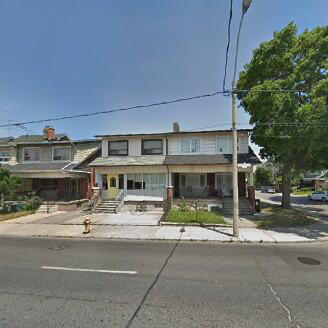

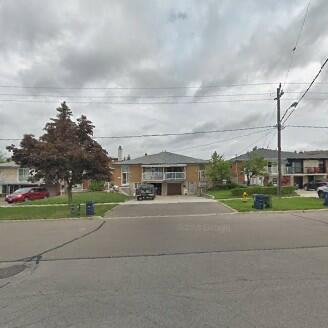

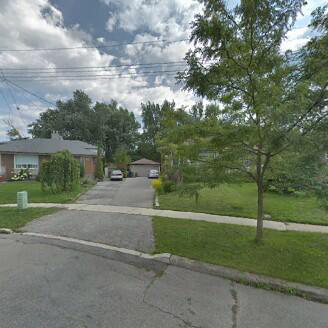

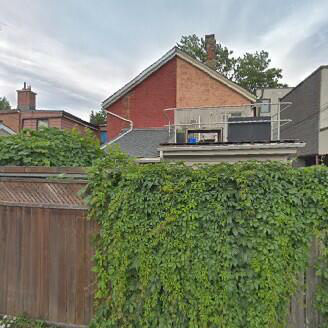

In [23]:
# displays 4 random images from Test set
from PIL import Image
img1 = Image.open("toronto/image/gsv_0.jpg")
img2 = Image.open("toronto/image/gsv_1.jpg")
img3 = Image.open("toronto/image/gsv_2.jpg")
img4 = Image.open("toronto/image/gsv_3.jpg")
display(img1)
display(img2)
display(img3)
display(img4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


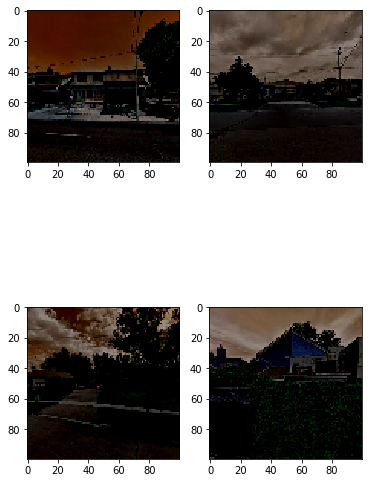

In [45]:
%matplotlib inline
xs = X[0:4]

n_cols = 2
n_rows = int(len(xs)/2)
plt.figure(figsize=(3*n_cols, 5*n_rows))
#plt.figure(figsize=(100, 100))
for i in range(len(xs)):
    plt.subplot(2, 2, i+1)
    plt.imshow(xs[i].reshape(100,100,3), cmap='gray')

In [48]:
from keras.models import Sequential, Model, load_model, model_from_yaml
# Load the model
yaml_file = open('model_keras_cnn_v3b.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
loaded_model = model_from_yaml(loaded_model_yaml)
# load weights into new model
loaded_model.load_weights("model_keras_cnn_v3b.h5")
print("Loaded model from disk")

Loaded model from disk


In [50]:
### Predictions on the selected input
input_x = X[0:4]
sample_prediction = loaded_model.predict_classes(input_x)
print(sample_prediction)

[0 0 0 0]


In [51]:
explainer = lime_image.LimeImageExplainer()

In [52]:
import skimage
print(skimage.__version__)

0.15.0


In [53]:
%%time
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(input_x[0], loaded_model.predict, top_labels=2, num_samples=1000)

CPU times: user 1.06 s, sys: 84 ms, total: 1.15 s
Wall time: 1.75 s


In [54]:
from skimage.segmentation import mark_boundaries

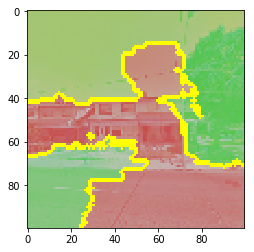

In [55]:
temp, mask = explanation.get_image_and_mask(sample_prediction[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [56]:
%%time
explanation = explainer.explain_instance(input_x[1], loaded_model.predict, top_labels=2, num_samples=1000)

CPU times: user 1.03 s, sys: 56 ms, total: 1.09 s
Wall time: 1.28 s


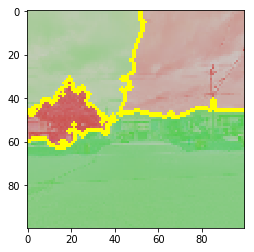

In [57]:
temp, mask = explanation.get_image_and_mask(sample_prediction[1], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [58]:
%%time
explanation = explainer.explain_instance(input_x[2], loaded_model.predict, top_labels=2, num_samples=1000)

CPU times: user 1.02 s, sys: 88 ms, total: 1.11 s
Wall time: 1.31 s


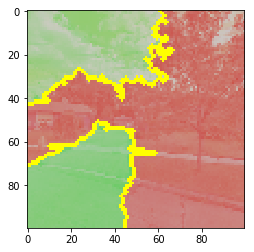

In [59]:
temp, mask = explanation.get_image_and_mask(sample_prediction[2], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [60]:
%%time
explanation = explainer.explain_instance(input_x[3], loaded_model.predict, top_labels=2, num_samples=1000)

CPU times: user 1.01 s, sys: 104 ms, total: 1.11 s
Wall time: 1.29 s


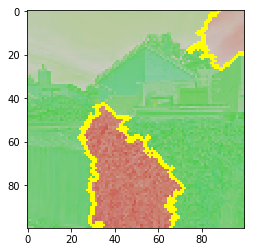

In [61]:
temp, mask = explanation.get_image_and_mask(sample_prediction[3], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))